## Medical Appointment No Shows

### Introduction

- Many times people do not show up for a medical appointment. Previous studies have shown that about 25% of the people do not show up.
- No-show is a loss for doctors since they lose their payments. On the other hand, patients who wanted an appointment as soon as possible were unable to get one.
- Thus, there are two losses: the financial loss for the doctor and the loss of an appointment for the person in need.
- The paper could help clinics and hospitals in understanding what attributes are associated with the individuals who did not show up.

### Loading Python libraries

In [113]:
import numpy as np
import pandas as pd

import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn as sk
from sklearn import tree
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from graphviz import Source
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,f1_score
import sklearn.metrics as met
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import scipy as sp 
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import lightgbm
from sklearn.model_selection import StratifiedKFold
 
from sklearn.datasets import make_classification  
from sklearn.neighbors import KNeighborsClassifier   
from sklearn.metrics import roc_curve
from sklearn.utils.multiclass import unique_labels

from IPython.display import SVG
from IPython.display import display
from IPython.display import Image  
import pydotplus

import warnings
warnings.filterwarnings('ignore')

###  Loading Dataset

* PatientId - Identification of a patient
* AppointmentID - Identification of each appointment
* Gender - Male or Female
* ScheduledDay - The day the patient asked to book the appointment, this is before or at the same day of AppointmentDay.
* AppointmentDay - The day day the the appointment is booked for.
* Age - How old is the patient.
* Neighbourhood - Where the appointment takes place.
* Scholarship - Aid offered by Government: True of False
* Hypertension - True or False
* Diabetes - True or False
* Alcoholism - True or False
* Handcap - Number of disabilites patient has: 0-4 (For example, if the person is blind and can't walk the total is 2).
* SMS_received - Reminder messages sent to the patient.
* No-show - Yes or No.

In [114]:
df = pd.read_csv("medical-appointment-no-shows.csv", converters={"PatientId":str})
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [115]:
df.shape

(110527, 14)

### Data Cleaning

#### Renaming Columns

In [116]:
df.columns=['PatientId', 'AppointmentId', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SmsReceived', 'NoShow']

In [117]:
df.columns

Index(['PatientId', 'AppointmentId', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SmsReceived', 'NoShow'],
      dtype='object')

####  Check for Null values in the dataset

In [118]:
df.isna().sum()

PatientId         0
AppointmentId     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hypertension      0
Diabetes          0
Alcoholism        0
Handicap          0
SmsReceived       0
NoShow            0
dtype: int64

There are no null values in the dataset

#### Extracting date from Scheduled Day

In [119]:
df["ScheduledDay"] = pd.to_datetime(df["ScheduledDay"])
df['ScheduledDate'] = df['ScheduledDay'].dt.date

#### Extracting date from Appointment Day

In [120]:
df["AppointmentDay"] = pd.to_datetime(df["AppointmentDay"]) ##COnverting Date from String type to Datetime format
df['AppointmentDate'] = df['AppointmentDay'].dt.date

#### Checking whether any Appointment days are before Scheduled days

In [121]:
len(df[df["AppointmentDay"] < df["ScheduledDay"]])

38568

'AppointmentDay' has no value for time of the day and it has 38568 values smaller than 'ScheduledDay' which is not correct.

The reason for this problem is that, probably these appointments happened at the same day that they're booked but because we don't have the exact hour for 'AppointmentDay' their difference is negative.

To solve this problem, we added 23 hrs and 59 min and 59 secs to the 'AppointmentDay'. 

In [122]:
df['AppointmentDay'] = df['AppointmentDay'] + pd.Timedelta('1d') - pd.Timedelta('1s')

In [123]:
len(df[ df.AppointmentDay < df.ScheduledDay ])

5

Now we have only 5 rows where ScheduledDay is later than AppointmentDay which can be dropped.

In [124]:
df.drop( df[df.AppointmentDay <= df.ScheduledDay].index, inplace=True)

#### Extracting day name from Scheduled day

In [125]:
df['ScheduledDay']=pd.to_datetime(df['ScheduledDay'])
df['ScheduledDayOfWeek']=df['ScheduledDay'].dt.date
df['ScheduledDayOfWeek']=pd.to_datetime(df['ScheduledDayOfWeek'])
df['ScheduledDayOfWeek'] = df['ScheduledDayOfWeek'].dt.day_name()

#### Extracting day name from Appointment day

In [126]:
df['AppointmentDay']=pd.to_datetime(df['AppointmentDay'])
df['AppointmentDayOfWeek']=df['AppointmentDay'].dt.date
df['AppointmentDayOfWeek']=pd.to_datetime(df['AppointmentDayOfWeek'])
df['AppointmentDayOfWeek'] = df['AppointmentDayOfWeek'].dt.day_name()

#### Converting Categorical values to Numeric values

In [127]:
d_replace = {"Yes": 1, "No": 0}
df = df.replace({"NoShow": d_replace})

#### Adding "Lead days" column

'Lead Days' is the number of days taken to book the appointment from when it was requested.

In [128]:
df['LeadDays'] = (df["AppointmentDay"] - df["ScheduledDay"]).astype('timedelta64[D]').astype(int)

### Analyzing the major factors contributing to No Shows of patients

In [129]:
df_for_plots = df.copy()

#### Age bins

In [130]:
def age_category(age):
    if(age<=15):
        return 1
    elif(age>15 and age<=30):
        return 2
    elif(age>30 and age<=45):
        return 3
    elif(age>45 and age<=60):
        return 4
    elif(age>60):
        return 5

df_for_plots['AgeCategory'] = df_for_plots.apply(lambda x: age_category(x['Age']), axis=1)

#### Lead Days bins

In [131]:
def lead_day_category(LeadDay):
    if(LeadDay<=2):
        return 'Within 2 Days'
    elif(LeadDay>2 and LeadDay<=7):
        return 'Within 1 Week'
    elif(LeadDay>7 and LeadDay<=14):
        return 'Within 2 Weeks'
    elif(LeadDay>14 and LeadDay<=21):
        return 'Within 3 Weeks'
    elif(LeadDay>21 and LeadDay<=28):
        return 'Within 4 Weeks'
    elif(LeadDay>28):
        return 'After 1 Month'


#### Finding distribution of patients by lead time

Creating a dataframe to calculate the percentage of people who miss their appointments, grouped by lead day category

In [132]:
df_for_plots['LeadDayCategory'] = df_for_plots.apply(lambda x: lead_day_category(x['LeadDays']), axis=1)

df_lead_days = df_for_plots.groupby(by=['LeadDayCategory', 'NoShow'])['PatientId'].agg(['count']).rename(columns={'count':'LeadDayCount'})
df_lead_days.reset_index(inplace=True)
df_lead_days = df_lead_days[df_lead_days['NoShow']==1]

df_total = df_for_plots[['LeadDayCategory', 'PatientId']]
df_total = df_total.groupby(by='LeadDayCategory')['PatientId'].agg(['count']).rename(columns={'count':'Total'})
df_total.reset_index(inplace=True)

df_lead_days = df_lead_days.merge(df_total, how='left', left_on=['LeadDayCategory'], right_on=['LeadDayCategory'])

df_lead_days['Percent'] = round((df_lead_days['LeadDayCount']*100) / df_lead_days['Total'], 2)
df_lead_days


,LeadDayCategory,NoShow,LeadDayCount,Total,Percent
0,After 1 Month,1,3968,12171,32.60
1,Within 1 Week,1,5057,20247,24.98
2,Within 2 Days,1,4507,50501,8.92
3,Within 2 Weeks,1,3664,12025,30.47
4,Within 3 Weeks,1,2861,8874,32.24
5,Within 4 Weeks,1,2257,6704,33.67


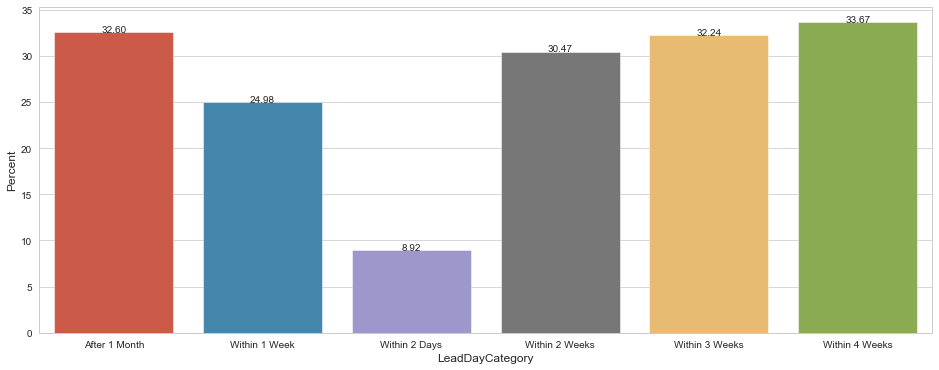

In [133]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

plt.figure(figsize=(16, 6))
sns.set_style("whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x=df_lead_days['LeadDayCategory'], y=df_lead_days['Percent'], data=tips)
show_values_on_bars(ax)

plt.show()

#### We subsitute the numerical values in column 'SmsReceived' to categorical values

In [134]:
df_for_plots['SmsReceived'] = df_for_plots['SmsReceived'].map({0:'SMS not received', 1:'SMS received'})

#### We consider 'Hypertension' and 'Diabetes' as Chronic illness and we classify Patients into 2 categories:
- Patients belonging to Age Category 5 and suffering from Chronic illness
- Patients belonging to Age Category 1-4 and suffering from Chronic illness

In [135]:
df_for_plots.loc[((df_for_plots['Hypertension'] == 1) | (df_for_plots['Diabetes'] == 1)) & (df_for_plots['AgeCategory']==5), 'Old_Chronic'] = 'OldChronic'
df_for_plots.loc[((df_for_plots['Hypertension'] == 1) | (df_for_plots['Diabetes'] == 1)) & (df_for_plots['AgeCategory']!=5), 'Old_Chronic'] = 'YoungChronic'

df_for_plots['Old_Chronic'] = df_for_plots['Old_Chronic'].fillna('Healthier')

df_for_plots.head()

Pct_Old_Chronic = round((df_for_plots[(df_for_plots['Old_Chronic']=='OldChronic') & (df_for_plots['NoShow']==1)]['PatientId'].count() \
/ df_for_plots[df_for_plots['NoShow']==1]['PatientId'].count()) * 100, 2)

Pct_Young_Chronic = round((df_for_plots[(df_for_plots['Old_Chronic']=='YoungChronic') & (df_for_plots['NoShow']==1)]['PatientId'].count() \
/ df_for_plots[df_for_plots['NoShow']==1]['PatientId'].count()) * 100, 2)

print("Patients belonging to Age Category 5 and suffering from Chronic illness: "+str(Pct_Old_Chronic))
print("Patients belonging to Age Category 1-4 and suffering from Chronic illness: "+str(Pct_Young_Chronic))

Patients belonging to Age Category 5 and suffering from Chronic illness: 8.2
Patients belonging to Age Category 1-4 and suffering from Chronic illness: 10.0


#### No Shows as per Neighbourhood

In [136]:
df_for_plots["All"]="Brazil"
fig = px.treemap(data_frame=df_for_plots,path=['All','Neighbourhood','Gender'],
                         values='NoShow',title='No Shows as per Neighbourhood')
fig.show()

#### Distribution of No Shows as per Number of Disabilities and Age Category

Text(0.5, 1, 'Distribution of No Shows as per Number of Disabilities and Age Category')

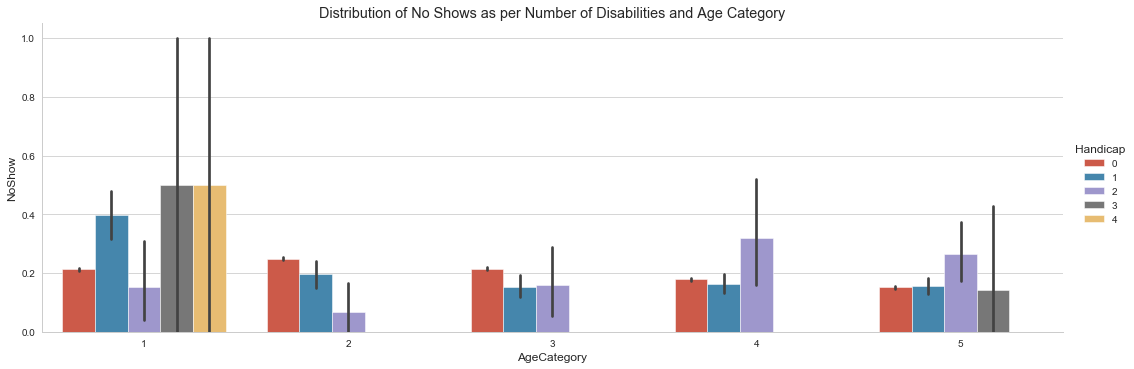

In [137]:
sns.catplot(x='AgeCategory', y='NoShow', hue='Handicap', data=df_for_plots, kind='bar',aspect=3)
plt.title("Distribution of No Shows as per Number of Disabilities and Age Category")

#### No Shows as per Age Category of Patients

Text(0.5, 1.0, 'No Shows as per Age Category of Patients')

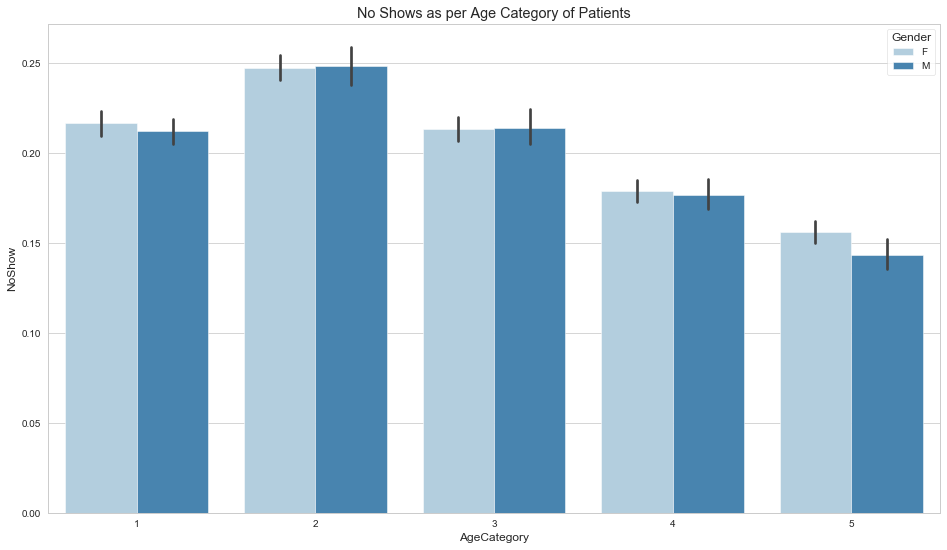

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.barplot(x=df_for_plots['AgeCategory'],y=df_for_plots['NoShow'],hue=df_for_plots['Gender'],palette='Blues')
plt.title("No Shows as per Age Category of Patients")

#### No Shows as per Appointment Day

Text(0.5, 1.0, 'No Shows as per Appointment Day')

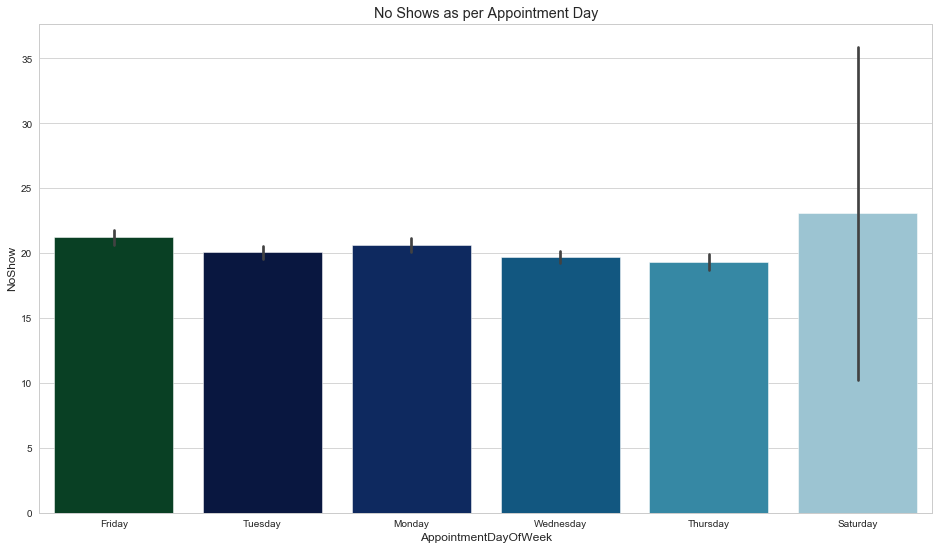

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.barplot(x=df_for_plots['AppointmentDayOfWeek'],y=df_for_plots['NoShow']*100,palette='ocean')
plt.title("No Shows as per Appointment Day")

#### No Shows as per number of Disabilities

Text(0.5, 1.0, 'No Shows as per number of Disabilities')

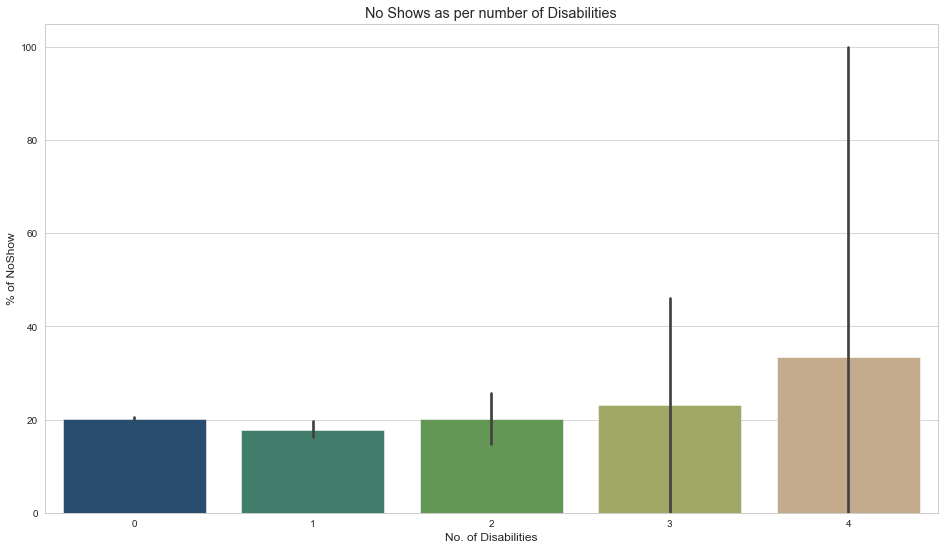

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
sns.barplot(x=df_for_plots['Handicap'],y=df_for_plots['NoShow']*100,palette='gist_earth')   
plt.xlabel("No. of Disabilities")
plt.ylabel("% of NoShow")
plt.title("No Shows as per number of Disabilities")

#### Distribution of No Shows as per Number of Chronic Illness

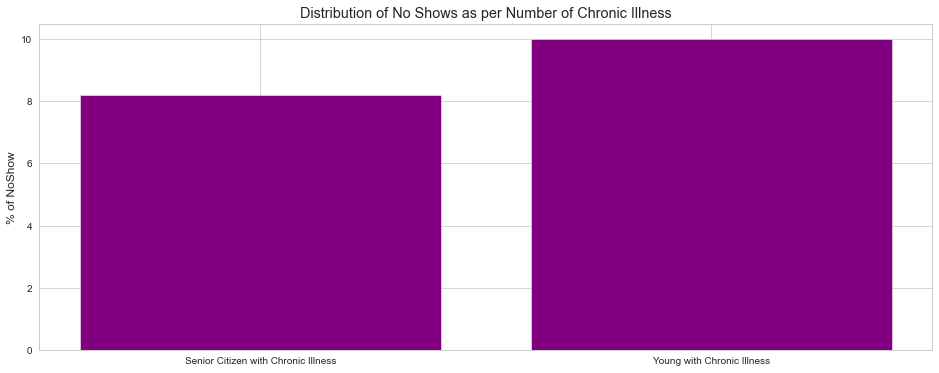

In [141]:
x = [8.19,10.0]
years = ['Senior Citizen with Chronic Illness', 'Young with Chronic Illness']

plt.figure(figsize=(16, 6))
plt.bar(years, x,color='Purple')
plt.ylabel("% of NoShow")
plt.title("Distribution of No Shows as per Number of Chronic Illness")
plt.show()

#### Effect of an SMS notification on No Shows

Text(0, 0.5, 'SMS Notification')

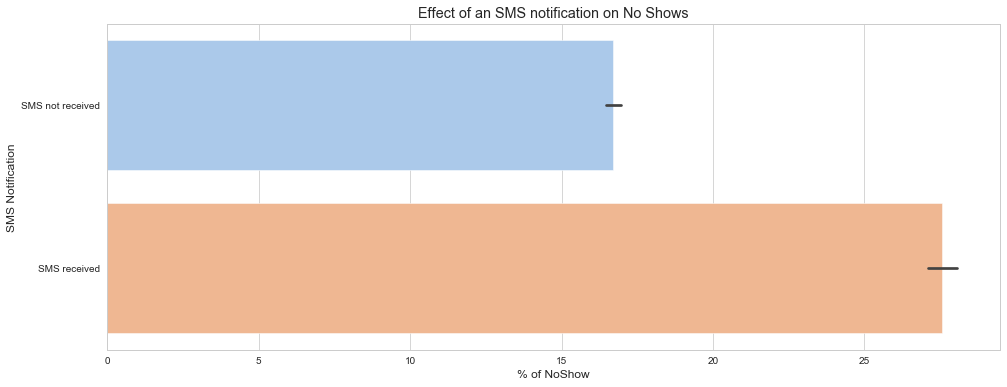

In [142]:
plt.figure(figsize=(16, 6))
sns.barplot(x=df_for_plots['NoShow']*100,y=df_for_plots['SmsReceived'],palette='pastel',orient='h') 
plt.xlabel("% of NoShow")
plt.title("Effect of an SMS notification on No Shows")
plt.ylabel('SMS Notification')

#### Effect of Waiting time on No Show

Text(0, 0.5, '% No Show')

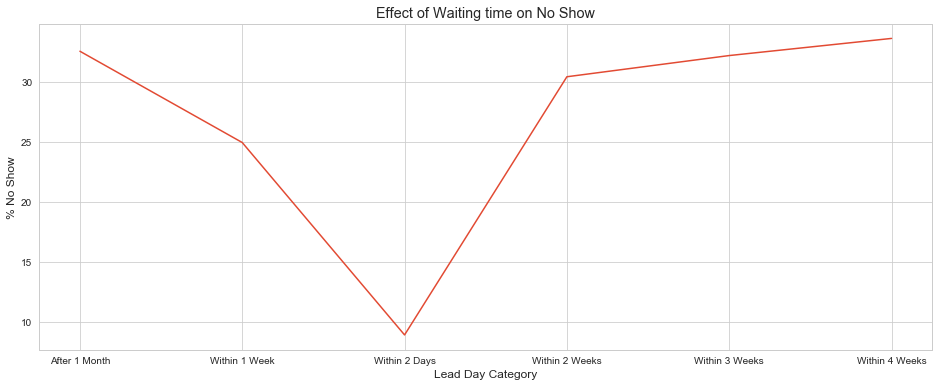

In [143]:
plt.figure(figsize=(16, 6))
sns.lineplot(x=df_lead_days['LeadDayCategory'],y=df_lead_days['Percent'])
plt.title("Effect of Waiting time on No Show")
plt.xlabel('Lead Day Category')
plt.ylabel('% No Show')

#### Following insights were drawn from the visualizations

* Patients with Age category 2 are more likely to miss their appointments
* In all of the top 10 Neighbourhoods with highest No-Shows, the proportion of females not showing up is more than males.
* Patients are most likely to show up if the day of their appointment is Saturday.
* Patients having Number of disabilities as 4 are are the one's with highest no-shows.
* Patients receiving an SMS Notification are more likely to not show-up for an appointment as compared to the one's not receiving an SMS notification. Hospitals needs to further assess their strategy about notifying patients for their appointments.
* Patients belonging to Age category 1 and having Number of disabilities as 3 and 4 are more likely to not show up.
* Younger patients (with age category between 1-4) suffering from Chronic illness(Diabetes and Hypertension) constitute a higher proportion of no-shows as compared to senior citizens (with age category 5) suffering from chronic illness.

### Machine Leaning


#### Decision Tree

#### Let's make a Decision Tree based on only the original columns

In [144]:
df_for_decision_tree = df.copy()

In [145]:
df_for_decision_tree.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow,ScheduledDate,AppointmentDate,ScheduledDayOfWeek,AppointmentDayOfWeek,LeadDays
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 23:59:59+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0
1,558997776694438,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0
2,4262962299951,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 23:59:59+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0
3,867951213174,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 23:59:59+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0
4,8841186448183,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 23:59:59+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,0,2016-04-29,2016-04-29,Friday,Friday,0


#### We extract the Original columns from modified dataset to check the accuracy of Decision Tree algorithm

In [146]:
df_for_decision_tree = df[['NoShow', 'Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SmsReceived', 'ScheduledDayOfWeek',\
        'ScheduledDay','AppointmentDay','AppointmentDayOfWeek']]

In [147]:
df_for_decision_tree['ScheduledDay'] = df_for_decision_tree['ScheduledDay'].dt.day
df_for_decision_tree['AppointmentDay'] = df_for_decision_tree['AppointmentDay'].dt.day

In [148]:
df_for_decision_tree.head()

,NoShow,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,ScheduledDayOfWeek,ScheduledDay,AppointmentDay,AppointmentDayOfWeek
0,0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,Friday,29,29,Friday
1,0,M,56,JARDIM DA PENHA,0,0,0,0,0,0,Friday,29,29,Friday
2,0,F,62,MATA DA PRAIA,0,0,0,0,0,0,Friday,29,29,Friday
3,0,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,Friday,29,29,Friday
4,0,F,56,JARDIM DA PENHA,0,1,1,0,0,0,Friday,29,29,Friday


#### We convert categorical values to dummies

In [149]:
df_for_decision_tree = pd.get_dummies(df_for_decision_tree, columns=['Neighbourhood','AppointmentDayOfWeek','ScheduledDayOfWeek','Gender'])


In [150]:
df_for_decision_tree.shape

(110522, 105)

In [151]:
X = df_for_decision_tree.drop('NoShow',axis=1)
Y = df_for_decision_tree['NoShow']
dt = tree.DecisionTreeClassifier(max_depth=2).fit(X,Y)

In [152]:
dt_feature_names = list(X.columns)
dt_target_names = [str(s) for s in Y.unique()]

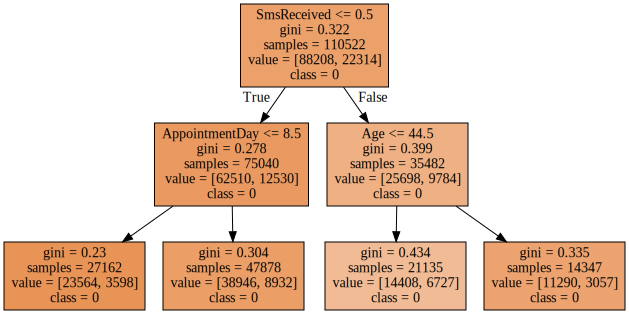

In [153]:
graph = Source(tree.export_graphviz(dt, out_file=None
  , feature_names=dt_feature_names, class_names=dt_target_names
  , filled = True))
display(SVG(graph.pipe(format='svg')))

The decision tree classifier classifies the data points into the same category, although our dataset isn't skewed. Hence, moving onto the next model

#### Random Forest Classifier

In [154]:
df_for_random_forest = df[['NoShow', 'Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension','Diabetes', \
                           'Alcoholism', 'Handicap', 'SmsReceived', 'ScheduledDayOfWeek','ScheduledDay',\
                           'AppointmentDay','AppointmentDayOfWeek']]

In [155]:
df_for_random_forest = pd.get_dummies(df_for_random_forest,columns=['Neighbourhood', 'AppointmentDayOfWeek'])
df_for_random_forest.head()

,NoShow,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,ScheduledDayOfWeek,ScheduledDay,AppointmentDay,Neighbourhood_AEROPORTO,Neighbourhood_ANDORINHAS,Neighbourhood_ANTÔNIO HONÓRIO,Neighbourhood_ARIOVALDO FAVALESSA,Neighbourhood_BARRO VERMELHO,Neighbourhood_BELA VISTA,Neighbourhood_BENTO FERREIRA,Neighbourhood_BOA VISTA,Neighbourhood_BONFIM,Neighbourhood_CARATOÍRA,Neighbourhood_CENTRO,Neighbourhood_COMDUSA,Neighbourhood_CONQUISTA,Neighbourhood_CONSOLAÇÃO,Neighbourhood_CRUZAMENTO,Neighbourhood_DA PENHA,Neighbourhood_DE LOURDES,Neighbourhood_DO CABRAL,Neighbourhood_DO MOSCOSO,Neighbourhood_DO QUADRO,Neighbourhood_ENSEADA DO SUÁ,Neighbourhood_ESTRELINHA,Neighbourhood_FONTE GRANDE,Neighbourhood_FORTE SÃO JOÃO,Neighbourhood_FRADINHOS,Neighbourhood_GOIABEIRAS,Neighbourhood_GRANDE VITÓRIA,Neighbourhood_GURIGICA,Neighbourhood_HORTO,Neighbourhood_ILHA DAS CAIEIRAS,Neighbourhood_ILHA DE SANTA MARIA,Neighbourhood_ILHA DO BOI,Neighbourhood_ILHA DO FRADE,Neighbourhood_ILHA DO PRÍNCIPE,Neighbourhood_ILHAS OCEÂNICAS DE TRINDADE,Neighbourhood_INHANGUETÁ,Neighbourhood_ITARARÉ,Neighbourhood_JABOUR,Neighbourhood_JARDIM CAMBURI,Neighbourhood_JARDIM DA PENHA,Neighbourhood_JESUS DE NAZARETH,Neighbourhood_JOANA D´ARC,Neighbourhood_JUCUTUQUARA,Neighbourhood_MARIA ORTIZ,Neighbourhood_MARUÍPE,Neighbourhood_MATA DA PRAIA,Neighbourhood_MONTE BELO,Neighbourhood_MORADA DE CAMBURI,Neighbourhood_MÁRIO CYPRESTE,Neighbourhood_NAZARETH,Neighbourhood_NOVA PALESTINA,Neighbourhood_PARQUE INDUSTRIAL,Neighbourhood_PARQUE MOSCOSO,Neighbourhood_PIEDADE,Neighbourhood_PONTAL DE CAMBURI,Neighbourhood_PRAIA DO CANTO,Neighbourhood_PRAIA DO SUÁ,Neighbourhood_REDENÇÃO,Neighbourhood_REPÚBLICA,Neighbourhood_RESISTÊNCIA,Neighbourhood_ROMÃO,Neighbourhood_SANTA CECÍLIA,Neighbourhood_SANTA CLARA,Neighbourhood_SANTA HELENA,Neighbourhood_SANTA LUÍZA,Neighbourhood_SANTA LÚCIA,Neighbourhood_SANTA MARTHA,Neighbourhood_SANTA TEREZA,Neighbourhood_SANTO ANDRÉ,Neighbourhood_SANTO ANTÔNIO,Neighbourhood_SANTOS DUMONT,Neighbourhood_SANTOS REIS,Neighbourhood_SEGURANÇA DO LAR,Neighbourhood_SOLON BORGES,Neighbourhood_SÃO BENEDITO,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM,AppointmentDayOfWeek_Friday,AppointmentDayOfWeek_Monday,AppointmentDayOfWeek_Saturday,AppointmentDayOfWeek_Thursday,AppointmentDayOfWeek_Tuesday,AppointmentDayOfWeek_Wednesday
0,0,F,62,0,1,0,0,0,0,Friday,2016-04-29 18:38:08+00:00,2016-04-29 23:59:59+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,M,56,0,0,0,0,0,0,Friday,2016-04-29 16:08:27+00:00,2016-04-29 23:59:59+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,F,62,0,0,0,0,0,0,Friday,2016-04-29 16:19:04+00:00,2016-04-29 23:59:59+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,F,8,0,0,0,0,0,0,Friday,2016-04-29 17:29:31+00:00,2016-04-29 23:59:59+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,F,56,0,1,1,0,0,0,Friday,2016-04-29 16:07:23+00:00,2016-04-29 23:59:59+00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


#### Converting categorical values of the Gender and ScheduledDayOfWeek into numeric values

In [156]:
df_for_random_forest['Gender'] = df_for_random_forest['Gender'].map({'M':1, 'F':0})
df_for_random_forest['ScheduledDayOfWeek'] = df_for_random_forest['ScheduledDayOfWeek'].map({'Monday':0, 'Tuesday':1,\
                                                                                             'Wednesday':2, 'Thursday':3,\
                                                                                             'Friday':4, 'Saturday':5})

As we have already extracted the date values from the ScheduledDay and AppointmentDay columns, dropping them as we do not need the timestamp. 

In [157]:
df_for_random_forest.drop(['ScheduledDay', 'AppointmentDay'], axis=1, inplace=True)

In [158]:
target = 'NoShow'
predictors = df_for_random_forest.columns[1:]

In [159]:
X = df_for_random_forest[predictors]
Y = df_for_random_forest[target]

X_train, X_test, Y_train, Y_test= \
train_test_split(X,Y,test_size=0.3,random_state = 5)

In [160]:
clf_rf = RandomForestClassifier(random_state = 5, n_estimators=100)
clf_rf.fit(X_train,Y_train)


y_pred_rf = clf_rf.predict(X_test)
y_pred_proba_rf = clf_rf.predict_proba(X_test)[:,1]

In [161]:
print('Accuracy: ',round(met.accuracy_score(Y_test, y_pred_rf), 4))
print('AUC score: ',round(met.roc_auc_score(Y_test, y_pred_proba_rf), 4))

Accuracy:  0.7618
AUC score:  0.6615


### AutoML

Now we want to try auto ml H2o:

First, we need to add the dataset into the h2o driverless app,

then split the data into train and test,

then set the accuracey, time and interpretability as you can see in the screenshot below

and finaly, we run the model.

After the calculation is done, you can see that the best model is LightGBM and AUC is 0.7403

In [162]:
Image(url= "https://i.ibb.co/6P1Wj26/H2-O-Appointment.png")

#### H2o gives the AUC of 0.7403

Let's create a model to produce better AUC:

First we try creating new columns(feature engineering)

Then we try different models to get the best AUC possibel(hyper parameter tuning)

### Feature Engineering

#### Added following new columns to extract more information from our dataset

* Prior No-Show Rate - No shows as a percentage of total appointments (hypothesis: some patients persistently miss their appointments)
* Status of the last appointment - Hypothesis: If you miss your last appointment, you are more likely to attend the next one.
* Number of previous appointments - Hypothesis: Patients with persistent conditions are more likely to attend.
* Days since last appointment - Difference in days between the last 2 appointments

Note-<br>
The following cell takes a while to run

In [163]:
%%time

df = df.sort_values(["PatientId","AppointmentDate"])
l_no_show_rates = []
l_last_shows = []
l_appts_counts = []
l_appts_lasts = []

for pat in df["PatientId"].unique():
    dfx = df[df["PatientId"] == pat]
    l_no_show = list(dfx["NoShow"])
    
    l_no_show_rate = [0]
    l_appts_last = [0]
    for i in range(1,len(dfx)):
        # no show rates
        rate_so_far = round((np.sum(l_no_show[0:i]) / i)*100,1)
        l_no_show_rate.append(rate_so_far)
        # appointments since last appointment
        dates_list = list(dfx["AppointmentDate"])
        l_appt_diff = (dates_list[i] - dates_list[i-1]).days
        l_appts_last.append(l_appt_diff)
        
    # appointment count
    l_appts_count = []
    for i in range(0,len(dfx)):
        l_appts = i+1
        l_appts_count.append(l_appts)
        
    l_no_show_rates.extend(l_no_show_rate)
    l_appts_counts.extend(l_appts_count)
    l_appts_lasts.extend(l_appts_last)
    
    # last show
    l_last_show = []
    l_last_show = [0] + l_no_show[:-1]
    l_last_shows.extend(l_last_show)   

df["NoShowRate"] = l_no_show_rates
df["LastShowStatus"] = l_last_shows
df["AppointmentCount"] = l_appts_counts
df["LastAppointmentDays"] = l_appts_lasts

df.head()

CPU times: user 11min 15s, sys: 2.34 s, total: 11min 17s
Wall time: 11min 20s


,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,NoShow,ScheduledDate,AppointmentDate,ScheduledDayOfWeek,AppointmentDayOfWeek,LeadDays,NoShowRate,LastShowStatus,AppointmentCount,LastAppointmentDays
84473,11111462625267,5715720,F,2016-05-18 14:58:29+00:00,2016-06-08 23:59:59+00:00,65,REPÚBLICA,0,1,0,0,0,1,0,2016-05-18,2016-06-08,Wednesday,Wednesday,21,0.0,0,1,0
51059,111124532532143,5531224,M,2016-03-31 09:17:26+00:00,2016-05-03 23:59:59+00:00,9,MARIA ORTIZ,0,0,0,0,0,1,0,2016-03-31,2016-05-03,Thursday,Tuesday,33,0.0,0,1,0
95359,111124532532143,5624030,M,2016-04-26 15:05:58+00:00,2016-06-01 23:59:59+00:00,9,MARIA ORTIZ,0,0,0,0,0,1,1,2016-04-26,2016-06-01,Tuesday,Wednesday,36,0.0,0,2,29
60744,11114485119737,5621757,F,2016-04-26 10:46:38+00:00,2016-05-25 23:59:59+00:00,12,MARIA ORTIZ,0,0,0,0,0,1,1,2016-04-26,2016-05-25,Tuesday,Wednesday,29,0.0,0,1,0
2321,11116239871275,5625265,F,2016-04-27 07:05:38+00:00,2016-04-29 23:59:59+00:00,13,SÃO PEDRO,0,0,0,0,0,0,0,2016-04-27,2016-04-29,Wednesday,Friday,2,0.0,0,1,0


In [164]:
df.to_csv("after_preprocessing.csv")

In [165]:
df['ScheduledDayDay'] = df['ScheduledDay'].dt.day
df['AppointmentDayDay'] = df['AppointmentDay'].dt.day

Now we create a new dataframe with these new columns

In [166]:
df_ml = df[['NoShow', 'Gender', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension','Diabetes', 'Alcoholism', \
            'Handicap', 'SmsReceived','LeadDays', 'ScheduledDayOfWeek','ScheduledDayDay','AppointmentDayDay',\
            'AppointmentDayOfWeek','NoShowRate','LastShowStatus', 'AppointmentCount', 'LastAppointmentDays']]

In [167]:
df_ml.head()

,NoShow,Gender,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,LeadDays,ScheduledDayOfWeek,ScheduledDayDay,AppointmentDayDay,AppointmentDayOfWeek,NoShowRate,LastShowStatus,AppointmentCount,LastAppointmentDays
84473,0,F,65,REPÚBLICA,0,1,0,0,0,1,21,Wednesday,18,8,Wednesday,0.0,0,1,0
51059,0,M,9,MARIA ORTIZ,0,0,0,0,0,1,33,Thursday,31,3,Tuesday,0.0,0,1,0
95359,1,M,9,MARIA ORTIZ,0,0,0,0,0,1,36,Tuesday,26,1,Wednesday,0.0,0,2,29
60744,1,F,12,MARIA ORTIZ,0,0,0,0,0,1,29,Tuesday,26,25,Wednesday,0.0,0,1,0
2321,0,F,13,SÃO PEDRO,0,0,0,0,0,0,2,Wednesday,27,29,Friday,0.0,0,1,0


Converting categorical values of the Gender, AppointmentDayOfWeek and ScheduledDayOfWeek into numeric values

In [168]:
df_ml['Gender'] = df_ml['Gender'].map({'M':1, 'F':0})
df_ml['ScheduledDayOfWeek'] = df_ml['ScheduledDayOfWeek'].map({'Monday':0, 'Tuesday':1, 'Wednesday':2, \
                                                               'Thursday':3, 'Friday':4, 'Saturday':5})
df_ml['AppointmentDayOfWeek'] = df_ml['AppointmentDayOfWeek'].map({'Monday':0, 'Tuesday':1, 'Wednesday':2, \
                                                               'Thursday':3, 'Friday':4, 'Saturday':5})

In [169]:
df_ml = pd.get_dummies(df_ml,columns=['Neighbourhood'])
df_ml

,NoShow,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SmsReceived,LeadDays,ScheduledDayOfWeek,ScheduledDayDay,AppointmentDayDay,AppointmentDayOfWeek,NoShowRate,LastShowStatus,AppointmentCount,LastAppointmentDays,Neighbourhood_AEROPORTO,Neighbourhood_ANDORINHAS,Neighbourhood_ANTÔNIO HONÓRIO,Neighbourhood_ARIOVALDO FAVALESSA,Neighbourhood_BARRO VERMELHO,Neighbourhood_BELA VISTA,Neighbourhood_BENTO FERREIRA,Neighbourhood_BOA VISTA,Neighbourhood_BONFIM,Neighbourhood_CARATOÍRA,Neighbourhood_CENTRO,Neighbourhood_COMDUSA,Neighbourhood_CONQUISTA,Neighbourhood_CONSOLAÇÃO,Neighbourhood_CRUZAMENTO,Neighbourhood_DA PENHA,Neighbourhood_DE LOURDES,Neighbourhood_DO CABRAL,Neighbourhood_DO MOSCOSO,Neighbourhood_DO QUADRO,Neighbourhood_ENSEADA DO SUÁ,Neighbourhood_ESTRELINHA,Neighbourhood_FONTE GRANDE,Neighbourhood_FORTE SÃO JOÃO,Neighbourhood_FRADINHOS,Neighbourhood_GOIABEIRAS,Neighbourhood_GRANDE VITÓRIA,Neighbourhood_GURIGICA,Neighbourhood_HORTO,Neighbourhood_ILHA DAS CAIEIRAS,Neighbourhood_ILHA DE SANTA MARIA,Neighbourhood_ILHA DO BOI,Neighbourhood_ILHA DO FRADE,Neighbourhood_ILHA DO PRÍNCIPE,Neighbourhood_ILHAS OCEÂNICAS DE TRINDADE,Neighbourhood_INHANGUETÁ,Neighbourhood_ITARARÉ,Neighbourhood_JABOUR,Neighbourhood_JARDIM CAMBURI,Neighbourhood_JARDIM DA PENHA,Neighbourhood_JESUS DE NAZARETH,Neighbourhood_JOANA D´ARC,Neighbourhood_JUCUTUQUARA,Neighbourhood_MARIA ORTIZ,Neighbourhood_MARUÍPE,Neighbourhood_MATA DA PRAIA,Neighbourhood_MONTE BELO,Neighbourhood_MORADA DE CAMBURI,Neighbourhood_MÁRIO CYPRESTE,Neighbourhood_NAZARETH,Neighbourhood_NOVA PALESTINA,Neighbourhood_PARQUE INDUSTRIAL,Neighbourhood_PARQUE MOSCOSO,Neighbourhood_PIEDADE,Neighbourhood_PONTAL DE CAMBURI,Neighbourhood_PRAIA DO CANTO,Neighbourhood_PRAIA DO SUÁ,Neighbourhood_REDENÇÃO,Neighbourhood_REPÚBLICA,Neighbourhood_RESISTÊNCIA,Neighbourhood_ROMÃO,Neighbourhood_SANTA CECÍLIA,Neighbourhood_SANTA CLARA,Neighbourhood_SANTA HELENA,Neighbourhood_SANTA LUÍZA,Neighbourhood_SANTA LÚCIA,Neighbourhood_SANTA MARTHA,Neighbourhood_SANTA TEREZA,Neighbourhood_SANTO ANDRÉ,Neighbourhood_SANTO ANTÔNIO,Neighbourhood_SANTOS DUMONT,Neighbourhood_SANTOS REIS,Neighbourhood_SEGURANÇA DO LAR,Neighbourhood_SOLON BORGES,Neighbourhood_SÃO BENEDITO,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM
84473,0,0,65,0,1,0,0,0,1,21,2,18,8,2,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51059,0,1,9,0,0,0,0,0,1,33,3,31,3,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
95359,1,1,9,0,0,0,0,0,1,36,1,26,1,2,0.0,0,2,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60744,1,0,12,0,0,0,0,0,1,29,1,26,25,2,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2321,0,0,13,0,0,0,0,0,0,2,2,27,29,4,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46976,0,0,8,1,0,0,0,0,1,35,2,20,25,2,100.0,1,2,12,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [170]:
df_ml.shape

(110522, 99)

In [171]:
target = 'NoShow'

In [172]:
predictors = df_ml.columns[1:]

### RandomForest Classifier

We run Random Forest Classifier on the new Data Set

In [173]:
from sklearn.model_selection import train_test_split

X = df_ml[predictors]
Y = df_ml[target]


X_train, X_test, Y_train, Y_test= \
train_test_split(X,Y,test_size=0.3,random_state = 0)

In [174]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state = 5, n_estimators=100)
clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

In [175]:
y_pred = clf.predict(X_test)

In [176]:
y_pred_proba = clf.predict_proba(X_test)[:,1]

In [177]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met

confusion_matrix(Y_test,y_pred)

array([[25523,   856],
       [ 5697,  1081]])

Accuracy-

In [178]:
round(met.accuracy_score(Y_test, y_pred), 4)

0.8024

AUC Score-

In [179]:
round(met.roc_auc_score(Y_test, y_pred_proba), 4)

0.7441

In [180]:
l=[]
for feature in zip(predictors, clf.feature_importances_):
    l.append(feature)
    
df_importance = pd.DataFrame(l,columns=["Variable","Importance"])\
.sort_values("Importance", ascending=False)

#### Printing the importance of each column

In [181]:
plt.style.use('ggplot')

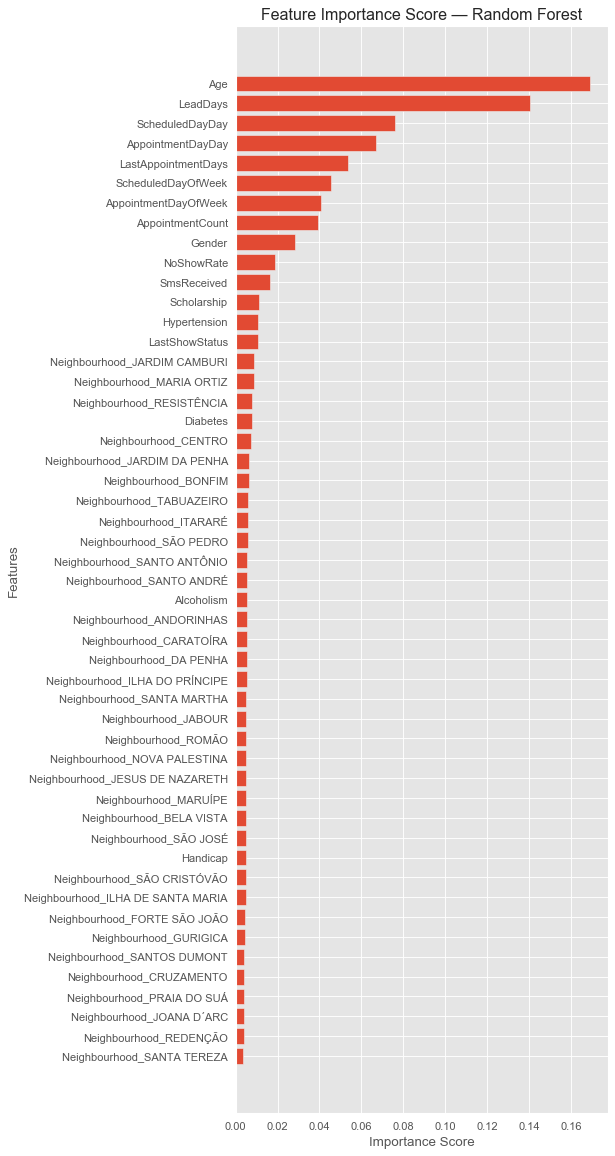

In [183]:
feature_importances = pd.DataFrame(clf.feature_importances_,
 index = predictors,
 columns=['importance']).sort_values('importance',
 ascending=False)
num = min([50,len(predictors)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(6, 18), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score — Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

#### H2o declared Light GBM as the best model, let's try it.

#### Light GBM Classifier

Light GBM doesn't work with non ASCII characters, so we need to drop these letters from column names. 

In [184]:
# Need to rename columns here, because Light GBM doesnt like non_ASCII column names
cols_l = df_ml.columns
cols_l_new = []
for col_name in cols_l:
    col_name_new = str(col_name).encode("ascii", "ignore").decode()
    cols_l_new.append(col_name_new)
    
df_ml.columns = cols_l_new
predictors = df_ml.columns[1:]

In [185]:
X = df_ml[predictors]
Y = df_ml[target]


X_train, X_test, Y_train, Y_test= \
train_test_split(X,Y,test_size=0.3,random_state = 0)

### Hyper Parameter Tuning

We have tried many different combinations of parameters manualy to get the best result.

These parameters are the best!

In [186]:
clf_lgbm = lightgbm.LGBMClassifier(
    n_estimators=500,
    n_jobs=-1,
    num_leaves = 51,
    objective = 'binary',
    learning_rate = 0.065,
    feature_fraction = 0.7,
    metric = 'auc'
)

Note-<br>
The next cell takes a while to run

In [187]:
%%time
clf_lgbm.fit(X_train, Y_train)


CPU times: user 10.9 s, sys: 92.4 ms, total: 11 s
Wall time: 1.51 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.7, importance_type='split',
               learning_rate=0.065, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=51, objective='binary',
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [188]:
y_pred_lgbm = clf_lgbm.predict(X_test)

In [189]:
y_pred_proba_lgbm = clf_lgbm.predict_proba(X_test)[:,1]

Accuracy-

In [190]:
round(met.accuracy_score(Y_test, y_pred_lgbm), 4)

0.8094

AUC Score-

In [191]:
round(met.roc_auc_score(Y_test, y_pred_proba_lgbm), 4)

0.7609

Light GBM is a super fast and accurate model, Let's compare it with a highly tuned XGBoost model!

### XGBoost Classifier

XGBoost is one the most powerful models

Note-<br>
The next cell takes a while to run

In [192]:
%%time


def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    
    clf = XGBClassifier(
        n_estimators=100,
        n_jobs=-1,
        **params
    )

    score = cross_val_score(clf, X_train, Y_train, scoring='accuracy', cv=StratifiedKFold()).mean()
    print("Accuracy {:.8f} params {}".format(-score, params))
    return -score

space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    'reg_lambda': hp.uniform('reg_lambda', 0.7, 1.0),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)


Accuracy -0.80699283 params {'max_depth': 3, 'gamma': '0.010', 'reg_alpha': '0.060', 'learning_rate': '0.077', 'colsample_bytree': '0.928'}
Accuracy -0.80860854 params {'max_depth': 4, 'gamma': '0.407', 'reg_alpha': '0.150', 'learning_rate': '0.153', 'colsample_bytree': '0.764'}
Accuracy -0.80738060 params {'max_depth': 3, 'gamma': '0.302', 'reg_alpha': '0.294', 'learning_rate': '0.123', 'colsample_bytree': '0.899'}
Accuracy -0.80876365 params {'max_depth': 5, 'gamma': '0.255', 'reg_alpha': '0.033', 'learning_rate': '0.178', 'colsample_bytree': '0.645'}
Accuracy -0.80762619 params {'max_depth': 3, 'gamma': '0.184', 'reg_alpha': '0.031', 'learning_rate': '0.131', 'colsample_bytree': '0.734'}
Accuracy -0.80620436 params {'max_depth': 2, 'gamma': '0.166', 'reg_alpha': '0.208', 'learning_rate': '0.096', 'colsample_bytree': '0.963'}
Accuracy -0.80745815 params {'max_depth': 4, 'gamma': '0.310', 'reg_alpha': '0.115', 'learning_rate': '0.147', 'colsample_bytree': '0.453'}
Accuracy -0.80902217

In [193]:
best['max_depth'] = int(best['max_depth'])

print("BEST PARAMS: ", best)

BEST PARAMS:  {'colsample_bytree': 0.493901699675865, 'gamma': 0.47067074323420127, 'learning_rate': 0.09076841667548786, 'max_depth': 7, 'reg_alpha': 0.20021551559722273, 'reg_lambda': 0.9026427495232137}


In [194]:
clf_xgb = XGBClassifier(
        n_estimators=600,
        n_jobs=-1,
        **best
    )

Note-<br>
The next cell takes a while to run

In [195]:
%%time

clf_xgb.fit(X_train, Y_train)

CPU times: user 6min 44s, sys: 1.48 s, total: 6min 45s
Wall time: 54.4 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.493901699675865,
              gamma=0.47067074323420127, learning_rate=0.09076841667548786,
              max_delta_step=0, max_depth=7, min_child_weight=1, missing=None,
              n_estimators=600, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0,
              reg_alpha=0.20021551559722273, reg_lambda=0.9026427495232137,
              scale_pos_weight=1, seed=None, silent=None, subsample=1,
              verbosity=1)

In [196]:
y_pred_xgb = clf_xgb.predict(X_test)
y_pred_proba_xgb = clf_xgb.predict_proba(X_test)[:,1]

Accuracy-

In [197]:
round(met.accuracy_score(Y_test, y_pred_xgb), 4)

0.8074

AUC Score-

In [198]:
round(met.roc_auc_score(Y_test, y_pred_proba_xgb), 4)

0.7611

XG Boost Classifier is the most accurate model.

### Plot ROC curve

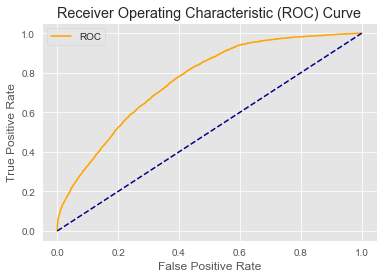

In [199]:
fper, tper, thresholds = roc_curve(Y_test, y_pred_proba_xgb) 
plt.plot(fper, tper, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Summary of machine learning

The first model we created gave us the AUC = 0.7441
But then we did some feature engineering and try different models (Light GBM and XGBoost) and tune their parameters and reached the AUC of 0.7609


### Prediction

After creating the prediction model with AUC of 0.76, we realised that showing up for an appointment is not easy to predict.

All analysis to solve this problem results in AUC around 0.75 which makes a lot of sense because at the end of the day we, humans are unpredictable. A lot of factors may cause a person not showing up for an appointment (for example a sick child or an emergency issue)

### Working with H2O

We used H2O to find out the best ML Predictive model for our dataset. We found that Light GBM and XGBoost were the most accurate models. This helped us to devote more time on making the existing ML model more efficient. Once we were sure about the model to work on, we coupled feature engineering with hyper-parameter tuning to obtain our desired outcome.
The interface was user friendly and the in-built tutorials helped us to locate various functionalities easily which we wished to perform.